In [1]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'

# Debt Market Model

# Setup and Dependencies

In [2]:
# Set project root folder, to enable importing project files from subdirectories
from pathlib import Path
import os

path = Path().resolve()
root_path = str(path).split('notebooks')[0]
os.chdir(root_path)

In [3]:
# Display cadCAD version for easy debugging
%pip show cadCAD

Name: cadCAD
Version: 0.4.23
Summary: cadCAD: a differential games based simulation software package for research, validation, and         Computer Aided Design of economic systems
Home-page: https://github.com/cadCAD-org/cadCAD
Author: Joshua E. Jodesty
Author-email: joshua@block.science
License: LICENSE.txt
Location: /Users/bscholtz/workspace/reflexer/venv/lib/python3.8/site-packages
Requires: fn, funcy, pathos, pandas
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [4]:
from shared import *

In [5]:
import numpy as np
import datetime as dt
import pandas as pd
import pickle
import math
import ast

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# import plotly.io as pio
# pio.renderers.default = "png"

from models.config_wrapper import ConfigWrapper
import models.system_model_v2 as system_model_v2

# Historical MakerDAO Dai debt market activity

In [6]:
debt_market_df = pd.read_csv('models/market_model/data/debt_market_df.csv', index_col='date', parse_dates=True)
debt_market_df

,rho_star,beta,p,Q,v_1,v_2 + v_3,u_1,u_2 + u_3,u_2,w_2,u_3,w_3,w_2 + w_3,D_1,D_2,w_1,D,C_star,p_star,p_ema_10
date,,,,,,,,,,,,,,,,,,,,
2017-12-18,736.004090,0.005,1.017605,2.425662e+03,2526.662000,101.000000,5.953420e+05,4.594384e+01,1.000000e+01,0.000006,35.943840,0.000023,0.000029,5.952961e+05,0.000000e+00,0.000000,5.952961e+05,1.785297e+06,1,1.008573
2017-12-19,832.236972,0.005,1.003376,6.240431e+03,3821.320309,6.550995,1.379832e+06,3.539448e+04,3.536748e+04,0.455885,27.000000,0.000348,0.456233,1.939733e+06,2.604943e+01,26.505662,1.939759e+06,5.193518e+06,1,1.008573
2017-12-20,810.287507,0.005,1.012972,1.418307e+04,8066.895210,124.255903,2.676383e+06,5.022518e+05,5.014128e+05,0.178879,839.000000,0.000299,0.179179,4.113865e+06,8.208488e+01,56.214632,4.113947e+06,1.149236e+07,1,1.008573
2017-12-21,837.231080,0.005,1.025738,1.564473e+04,1471.742069,10.080000,8.053550e+05,4.978271e+04,4.978271e+04,1.158909,0.000000,0.000000,1.158909,4.869437e+06,1.474660e+02,66.539983,4.869584e+06,1.309826e+07,1,1.008573
2017-12-22,689.014990,0.005,0.972228,1.883084e+04,5316.960481,2130.848985,3.145512e+05,7.474531e+05,7.239153e+05,19.756468,23537.818000,0.642374,20.398842,4.436535e+06,1.876926e+02,60.625449,4.436723e+06,1.297473e+07,1,1.008573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-26,167.637314,0.125,1.021405,1.525944e+06,56696.770732,29566.578527,8.079170e+05,1.585480e+06,1.515115e+06,64257.311824,70364.380268,2984.212338,67241.524162,7.957442e+07,4.562428e+06,27167.708945,8.413685e+07,2.558052e+08,1,1.008076
2019-09-27,167.347085,0.125,1.007346,1.529959e+06,7598.158072,3582.812664,6.087607e+05,6.367461e+05,6.366783e+05,7214.430099,67.790257,0.768156,7215.198255,7.954644e+07,4.582358e+06,27145.743151,8.412880e+07,2.560342e+08,1,1.009903
2019-09-28,174.289775,0.125,1.011006,1.528450e+06,876.961579,2386.452089,2.251956e+05,1.452312e+05,1.452062e+05,492.589362,25.000000,0.084809,492.674170,7.962640e+07,4.609044e+06,27177.983765,8.423545e+07,2.663932e+08,1,1.011184


In [7]:
debt_market_df.insert(0, 'seconds_passed', 24 * 3600)
debt_market_df['cumulative_v_1'] = debt_market_df['v_1'].cumsum()

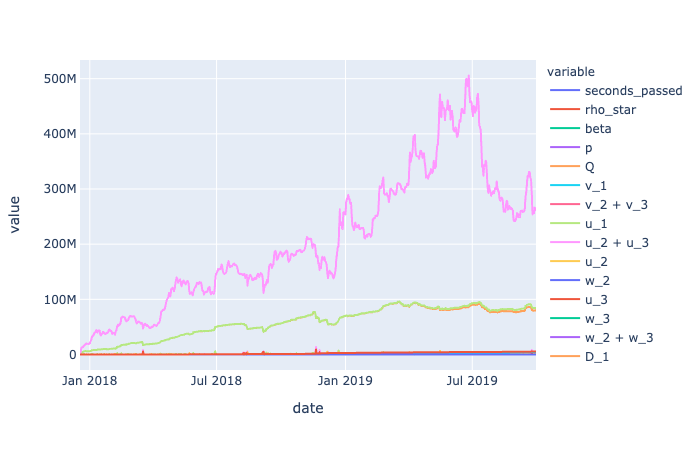

In [8]:
debt_market_df.plot()

# APT Model Setup

In [9]:
features = ['beta', 'Q', 'v_1', 'v_2 + v_3', 
                    'D_1', 'u_1', 'u_2', 'u_3', 'u_2 + u_3', 
                    'D_2', 'w_1', 'w_2', 'w_3', 'w_2 + w_3',
                    'D']

features_ml = ['beta', 'Q', 'v_1', 'v_2 + v_3', 'u_1', 'u_2', 'u_3', 'w_1', 'w_2', 'w_3', 'D']
optvars = ['u_1', 'u_2', 'v_1', 'v_2 + v_3']

## Root function

In [10]:
# NB: Pickle files must be downloaded seperately and copied into `models/pickes/` directory

model = pickle.load(open('models/pickles/apt_debt_model_2020-11-28.pickle', 'rb'))

# ML debt model root function
def G(x, to_opt, data, constant):
    for i,y in enumerate(x):
        data[:,to_opt[i]] = y
    err = model.predict(data)[0] - constant
    return err

dpres = pickle.load(open('models/pickles/debt_market_OLS_model.pickle', 'rb'))

def G_OLS(x, to_opt, data, constant):
    for i,y in enumerate(x):
        data[:,to_opt[i]] = y
    err = dpres.predict(data)[0] - constant
    #print(f'G_OLS err: {err}')
    return err

ml_data_list = []
global tol
tol = 1e-2
global curr_error, best_error, best_val
global strikes
strikes = 0
best_error = 1e10

def glf_continue_callback(xopt):
    print('entered callback')
    global curr_error, best_error, best_val, strikes, tol
    if curr_error > tol: # keep searching
        print('bigger than tol, keep searching')
        return False
    else:
        if curr_error > best_error: # add strike
            strikes += 1
            if strikes < 3: # continue trying
                print('bigger than prev best, add strike')
                return False
            else: # move on, not working
                strikes = 0
                print('3rd strike, stop')
                return True
        else: # better outcome, continue
            best_error = curr_error
            best_val = xopt
            strikes = 0
            print('New best, reset strikes')
            return False

# Global minimizer function
def glf(x, to_opt, data, constant, timestep):
    global curr_error
    for i,y in enumerate(x):
        data[:,to_opt[i]] = y
    err = model.predict(data)[0] - constant
    curr_error = abs(err)

    return curr_error

# Model Configuration

In [11]:
# Select the start date from historical data to use as the model initial state

# start_date = '2018-11-05' # Dropping ETH price
# start_date = '2018-05-06' # Dropping ETH price
start_date = '2018-04-01' # Rising ETH price

historical_initial_state = {k: debt_market_df.loc[start_date][k] for k in features}
historical_initial_state

{'beta': 0.005,
 'Q': 130417.5685990905,
 'v_1': 3575.828421456681,
 'v_2 + v_3': 75.28608947093743,
 'D_1': 19377432.0069828,
 'u_1': 397538.45749999577,
 'u_2': 33461.767846354865,
 'u_3': 233.40479179693645,
 'u_2 + u_3': 33695.172638151795,
 'D_2': 9035.78589335348,
 'w_1': 264.9046197045797,
 'w_2': 6.757067083587955,
 'w_3': 0.04713235245204128,
 'w_2 + w_3': 6.8041994360399976,
 'D': 19386467.79287615}

In [12]:
# Pre-process the historical data for use in the model state and parameters

eth_price = pd.DataFrame(debt_market_df['rho_star'])
eth_p_mean = np.mean(eth_price.to_numpy().flatten())

mar_price = pd.DataFrame(debt_market_df['p'])
mar_p_mean = np.mean(mar_price.to_numpy().flatten())

eth_returns = ((eth_price - eth_price.shift(1))/eth_price.shift(1)).to_numpy().flatten()
eth_gross_returns = (eth_price / eth_price.shift(1)).to_numpy().flatten()

eth_returns_mean = np.mean(eth_returns[1:])

eth_p_mean, eth_returns_mean, mar_p_mean

(365.8127290676168, -0.0012148823654996293, 1.0004125645956772)

In [13]:
eth_price_ = eth_price.loc[start_date][0]

liquidation_ratio = 1.5 # 150%
liquidation_buffer = 2.0
target_price = 1.0

In [14]:
stability_fee = (historical_initial_state['beta'] * 30 / 365) / (30 * 24 * 3600)

In [15]:
partial_results = pd.DataFrame()
partial_results_file = f'''exports/system_model_v2/partial_results.pickle'''
partial_results.to_pickle(partial_results_file)

In [16]:
eth_collateral = historical_initial_state['Q']
eth_locked = debt_market_df.loc[:start_date]['v_1'].sum()
eth_freed = debt_market_df.loc[:start_date]['v_2 + v_3'].sum() / 2
eth_bitten = debt_market_df.loc[:start_date]['v_2 + v_3'].sum() / 2

print(f'''
{eth_collateral}
{eth_locked}
{eth_freed}
{eth_bitten}
''')

assert math.isclose(eth_collateral, eth_locked - eth_freed - eth_bitten, abs_tol=1e-6)

principal_debt = historical_initial_state['D_1']
rai_drawn = debt_market_df.loc[:start_date]['u_1'].sum()
rai_wiped = debt_market_df.loc[:start_date]['u_2'].sum()
rai_bitten = debt_market_df.loc[:start_date]['u_3'].sum()

print(f'''
{principal_debt}
{rai_drawn}
{rai_wiped}
{rai_bitten}
''')

assert math.isclose(principal_debt, rai_drawn - rai_wiped - rai_bitten, abs_tol=1e-6)

print(f'Collateralization ratio: {eth_collateral * eth_price_ / principal_debt * target_price}')


130417.5685990905
189872.3149593018
29727.37318010564
29727.37318010564


19377432.0069828
42320205.44783997
16068921.349645888
6873852.091211276

Collateralization ratio: 2.583272198102856


In [17]:
# At historical start date:
median_cdp_collateral = 2500 # dollars
mean_cdp_collateral = 50 # dollars
genesis_cdp_count = int(eth_collateral / mean_cdp_collateral)
genesis_cdp_count

2608

In [18]:
# Create a set of "genesis" CDPs

cdp_list = []
for i in range(genesis_cdp_count):
    cdp_list.append({
        'open': 1, # True/False == 1/0 for integer/float series
        'time': 0,
        'locked': eth_collateral / genesis_cdp_count,
        'drawn': principal_debt / genesis_cdp_count,
        'wiped': 0.0,
        'freed': 0.0,
        'w_wiped': 0.0,
        'v_bitten': 0.0,
        'u_bitten': 0.0,
        'w_bitten': 0.0,
        'dripped': 0.0
    })

cdps = pd.DataFrame(cdp_list)
cdps

,open,time,locked,drawn,wiped,freed,w_wiped,v_bitten,u_bitten,w_bitten,dripped
0,1,0,50.006736,7429.996935,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,50.006736,7429.996935,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,50.006736,7429.996935,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,50.006736,7429.996935,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,50.006736,7429.996935,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2603,1,0,50.006736,7429.996935,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2604,1,0,50.006736,7429.996935,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2605,1,0,50.006736,7429.996935,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2606,1,0,50.006736,7429.996935,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
market_price = debt_market_df.loc[start_date]['p']
market_price

0.9964722501277672

In [20]:
enable_apt_tests = False

apt_tests = [
        # {
        #     'enable': False,
        #     'params': {
        #         'optimal_values': {
        #             'v_1': lambda timestep=0, df=simulation_results_df: \
        #                 simulation_results_df.iloc[timestep]['optimal_values'].get('v_1', historical_initial_state['v_1']),
        #             'v_2 + v_3': lambda timestep=0, df=simulation_results_df: \
        #                 simulation_results_df.iloc[timestep]['optimal_values'].get('v_2 + v_3', historical_initial_state['v_2 + v_3']),
        #             'u_1': lambda timestep=0, df=simulation_results_df: \
        #                 simulation_results_df.iloc[timestep]['optimal_values'].get('u_1', historical_initial_state['u_1']),
        #             'u_2': lambda timestep=0, df=simulation_results_df: \
        #                 simulation_results_df.iloc[timestep]['optimal_values'].get('u_2', historical_initial_state['u_2'])
        #         }
        #     }
        # },
        # {
        #     'enable': False,
        #     'params': {
        #         'optimal_values': {
        #             'v_1': lambda timestep=0: historical_initial_state['v_1'],
        #             'v_2 + v_3': lambda timestep=0: historical_initial_state['v_2 + v_3'],
        #             'u_1': lambda timestep=0: historical_initial_state['u_1'],
        #             'u_2': lambda timestep=0: historical_initial_state['u_2']
        #         }
        #     }
        # },
        {
            'enable': True,
            'params': {
                'optimal_values': {
                    'v_1': lambda timestep=0: 1000,
                    'v_2 + v_3': lambda timestep=0: 500,
                    'u_1': lambda timestep=0: 100,
                    'u_2': lambda timestep=0: 50
                }
            }
        },
        # {
        #     'enable': False,
        #     'params': {
        #         'optimal_values': {
        #             'v_1': lambda timestep=0: 500,
        #             'v_2 + v_3': lambda timestep=0: 1000,
        #             'u_1': lambda timestep=0: 50,
        #             'u_2': lambda timestep=0: 100
        #         }
        #     }
        # }
]

In [21]:
initial_state = {
    'events': [],
    'cdps': cdps,
    'cdp_metrics': {},
    # Start time
    'timestamp': dt.datetime.strptime(start_date, '%Y-%m-%d'), # datetime
    # Loaded from exogenous parameter
    'eth_price': eth_price_, # dollars
    # v
    'eth_collateral': eth_collateral, # Q
    'eth_locked': eth_locked, # v1
    'eth_freed': eth_freed, # v2
    'eth_bitten': eth_bitten, # v3
    'v_1': historical_initial_state['v_1'],
    'v_2': historical_initial_state['v_2 + v_3'] / 2,
    'v_3': historical_initial_state['v_2 + v_3'] / 2,
    # u
    'principal_debt': principal_debt, # D1
    'rai_drawn': rai_drawn, # u1 "minted"
    'rai_wiped': rai_wiped, # u2
    'rai_bitten': rai_bitten, # u3
    'u_1': historical_initial_state['u_1'],
    'u_2': historical_initial_state['u_2'],
    'u_3': historical_initial_state['u_3'],
    # w
    'w_1': historical_initial_state['w_1'],
    'w_2': historical_initial_state['w_2'],
    'w_3': historical_initial_state['w_3'],
    'accrued_interest': historical_initial_state['D_2'],
    'stability_fee': stability_fee,
    'market_price': market_price,
    'target_price': target_price, # dollars == redemption price
    'target_rate': 0 / (30 * 24 * 3600), # per second interest rate (X% per month)
    'p_expected': target_price,
    'p_debt_expected': target_price,
}

initial_state.update(historical_initial_state)

# Set dataframe to start from start date
debt_market_df = debt_market_df.loc[start_date:]

parameters = {
    'debug': [True], # Print debug messages (see APT model)
    'raise_on_assert': [False], # See assert_log() in utils.py
    'test': apt_tests if enable_apt_tests else [{'enable': False}],
    'free_memory_states': [['cdps', 'events']], #'cdps',
    #'eth_market_std': [1],
    #'random_state': [np.random.RandomState(seed=0)],
    'new_cdp_proportion': [0.5],
    'new_cdp_collateral': [median_cdp_collateral],
    'liquidation_ratio': [liquidation_ratio], # %
    'liquidation_buffer': [liquidation_buffer], # multiplier applied to CDP collateral by users
    'stability_fee': [lambda timestep, df=debt_market_df: stability_fee], # df.iloc[timestep].beta / (365 * 24 * 3600), # per second interest rate (1.5% per month)
    'liquidation_penalty': [0], # 0.13 == 13%
    'cdp_top_up_buffer': [2],
    # Average CDP duration == 3 months: https://www.placeholder.vc/blog/2019/3/1/maker-network-report
    # The tuning of this parameter is probably off the average, because we don't have the CDP size distribution matched yet,
    # so although the individual CDPs could have an average debt age of 3 months, the larger CDPs likely had a longer debt age.
    'average_debt_age': [3 * (30 * 24 * 3600)], # delta t (seconds)
    'eth_price': [lambda timestep, df=debt_market_df: df.iloc[timestep].rho_star],
    #'v_1': [lambda state, _state_history, df=debt_market_df: df.iloc[state['timestep']].v_1], # Driven by historical data
    #'u_1': [lambda timestep, df=debt_market_df: df.iloc[timestep].u_1], # Driven by historical data
    'seconds_passed': [lambda timestep, df=debt_market_df: df.iloc[timestep].seconds_passed],
    # 'market_price': [lambda timestep, df=debt_market_df: target_price],
    # APT model
    # **{
    #     'use_APT_ML_model': [False],
    #     'root_function': [G_OLS], # glf, G, G_OLS
    #     'features': [features], # features_ml, features
    # },
    **{
        'use_APT_ML_model': [True],
        'root_function': [glf], # glf, G, G_OLS
        'callback': [glf_continue_callback], # glf callback
        'model': [model],
        'features': [features_ml], # features_ml, features
    },
    'freeze_feature_vector': [False], # Use the same initial state as the feature vector for each timestep
    'optvars': [optvars],
    'bounds': [[(xmin,debt_market_df[optvars].max()[i]) 
        for i,xmin in enumerate(debt_market_df[optvars].min())
    ]],
    'interest_rate': [1.0],
    'eth_p_mean': [eth_p_mean],
    'eth_returns_mean': [eth_returns_mean],
    'mar_p_mean': [mar_p_mean],
    # APT OLS model
    'alpha_0': [0],
    'alpha_1': [1],
    'beta_0': [1.0003953223600617],
    'beta_1': [0.6756295152422528],
    'beta_2': [3.86810578185312e-06],    
    # Controller
    'controller_enabled': [True],
    'kp': [5e-7], #proportional term for the stability controller: units 1/USD
    'ki': [lambda control_period=3600: -1e-7 / control_period], #integral term for the stability controller: units 1/(USD*seconds)
    'partial_results': [partial_results_file],
}

# Simulation Execution

In [22]:
SIMULATION_TIMESTEPS = 10 # len(debt_market_df) - 1
MONTE_CARLO_RUNS = 1

In [23]:
system_simulation = ConfigWrapper(system_model_v2, T=range(SIMULATION_TIMESTEPS), M=parameters, initial_state=initial_state)

In [24]:
del configs[:]

system_simulation.append()

(simulation_result, tensor_field, sessions) = run(drop_midsteps=False)

INFO:root:Started simulation
DEBUG:root:p_expected terms: (1, 0.9964722501277672, 1.0, 3.86810578185312e-06, 365.8127290676168, 383.822378472222, 0.6756295152422528, 1.0004125645956772, 0, 0.9990556338569321)
DEBUG:root:
    ##### APT model run #####
    Timestep: 1
    
DEBUG:root:
    feature_0: [[5.00000000e-03 1.30417569e+05 3.57582842e+03 7.52860895e+01
  3.97538457e+05 3.34617678e+04 2.33404792e+02 2.64904620e+02
  6.75706708e+00 4.71323525e-02 1.93864678e+07]]
    x0: [3.97538457e+05 3.34617678e+04 3.57582842e+03 7.52860895e+01]
    optvars: ['u_1', 'u_2', 'v_1', 'v_2 + v_3']
    p_expected: 0.9990556338569321
    

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (10, 55, 1, 49)
Execution Method: local_simulat

# Simulation Analysis

In [25]:
#simulation_result = pd.concat([simulation_result, debt_market_df.reset_index()], axis=1)

simulation_result = simulation_result.assign(eth_collateral_value = simulation_result.eth_collateral * simulation_result.eth_price)

simulation_result['collateralization_ratio'] = (simulation_result.eth_collateral * simulation_result.eth_price) / (simulation_result.principal_debt * simulation_result.target_price)

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

simulation_result

,index,events,error_star,error_star_integral,market_price,blockheight,timedelta,cumulative_time,timestamp,cdps,eth_price,eth_collateral,eth_locked,eth_freed,eth_bitten,v_1,v_2,v_3,principal_debt,rai_drawn,rai_wiped,rai_bitten,u_1,u_2,u_3,accrued_interest,system_revenue,stability_fee,interest_dripped,interest_wiped,interest_bitten,w_1,w_2,w_3,target_price,target_rate,p_expected,eth_return,eth_gross_return,optimal_values,cdp_metrics,p_debt_expected,beta,Q,v_2 + v_3,D_1,u_2 + u_3,D_2,w_2 + w_3,D,simulation,subset,run,substep,timestep,eth_collateral_value,collateralization_ratio
0,0,None,0.000000,0.000000,0.996472,0,0.0,0.0,2018-04-01,None,383.822378,130417.568599,189872.314959,29727.373180,29727.37318,3575.828421,37.643045,37.643045,1.937743e+07,4.232021e+07,1.606892e+07,6.873852e+06,3.975385e+05,3.346177e+04,233.404792,9035.785893,0.000000,1.585490e-10,0,0,0,264.904620,6.757067,0.047132,1.000000,0.000000e+00,1.000000,0.000000,0.0,{},{},1.000000,0.005,130417.568599,75.286089,1.937743e+07,33695.172638,9035.785893,6.804199,1.938647e+07,0,0,1,0,0,5.005718e+07,2.583272
1,1,None,0.000000,0.000000,0.996472,0,0.0,0.0,2018-04-01,None,383.822378,130417.568599,189872.314959,29727.373180,29727.37318,3575.828421,37.643045,37.643045,1.937743e+07,4.232021e+07,1.606892e+07,6.873852e+06,3.975385e+05,3.346177e+04,233.404792,9035.785893,0.000000,1.585490e-10,0,0,0,264.904620,6.757067,0.047132,1.000000,0.000000e+00,1.000000,0.000000,0.0,{},{},1.000000,0.005,130417.568599,75.286089,1.937743e+07,33695.172638,9035.785893,6.804199,1.938647e+07,0,0,1,1,1,5.005718e+07,2.583272
2,2,None,0.000000,0.000000,0.996472,0,86400.0,86400.0,2018-04-02,None,383.822378,130417.568599,189872.314959,29727.373180,29727.37318,3575.828421,37.643045,37.643045,1.937743e+07,4.232021e+07,1.606892e+07,6.873852e+06,3.975385e+05,3.346177e+04,233.404792,9035.785893,0.000000,1.585490e-10,0,0,0,264.904620,6.757067,0.047132,1.000000,0.000000e+00,1.000000,0.000000,0.0,{},{},1.000000,0.005,130417.568599,75.286089,1.937743e+07,33695.172638,9035.785893,6.804199,1.938647e+07,0,0,1,2,1,5.005718e+07,2.583272
3,3,None,0.000000,0.000000,0.996472,0,86400.0,86400.0,2018-04-02,None,383.822378,130417.568599,189872.314959,29727.373180,29727.37318,3575.828421,37.643045,37.643045,1.937743e+07,4.232021e+07,1.606892e+07,6.873852e+06,3.975385e+05,3.346177e+04,233.404792,9035.785893,0.000000,1.585490e-10,0,0,0,264.904620,6.757067,0.047132,1.000000,0.000000e+00,0.999056,0.000000,0.0,{},{},1.000000,0.005,130417.568599,75.286089,1.937743e+07,33695.172638,9035.785893,6.804199,1.938647e+07,0,0,1,3,1,5.005718e+07,2.583272
4,4,None,0.000000,0.000000,0.996472,0,86400.0,86400.0,2018-04-02,None,383.822378,130417.568599,189872.314959,29727.373180,29727.37318,3575.828421,37.643045,37.643045,1.937743e+07,4.232021e+07,1.606892e+07,6.873852e+06,3.975385e+05,3.346177e+04,233.404792,9035.785893,0.000000,1.585490e-10,0,0,0,264.904620,6.757067,0.047132,1.000000,0.000000e+00,0.999056,0.000000,0.0,"{'u_1': 5939075.329459504, 'u_2': 398730.32597...",{},1.000000,0.005,130417.568599,75.286089,1.937743e+07,33695.172638,9035.785893,6.804199,1.938647e+07,0,0,1,4,1,5.005718e+07,2.583272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,176,[],-0.002805,-309.427991,1.001948,0,86400.0,864000.0,2018-04-11,open time locked dra...,402.394802,631731.892129,928083.638476,240852.841354,29727.37318,63716.089011,37944.557199,0.000000,8.484062e+07,1.258214e+08,2.866343e+07,9.232757e+06,4.470310e+06,1.385727e+06,0.000000,16988.904090,1207.198396,1.585490e-10,0,0,0,93.171949,99.315261,0.000000,0.999706,-1.044305e-09,1.000977,-0.004489,1.0,"{'u_1': 2524129.2495775353, 'u_2': 1385726.596...","{'cdp_count': 2669, 'open_cdp_count': 2663, 'c...",1.001172,0.005,130417.568599,75.286089,1.937743e+07,33695.172638,9035.785893,6.804199,1.938647e+07,0,0,1,14,10,2.542056e+0

## Save simulation

In [28]:
simulation_result.to_pickle(f'./exports/system_model_v2/results.pickle')

# Simulation Analysis

In [29]:
simulation_result = pd.read_pickle(f'exports/system_model_v2/results.pickle')

df = drop_dataframe_midsteps(simulation_result)
df

,level_0,index,events,error_star,error_star_integral,market_price,blockheight,timedelta,cumulative_time,timestamp,cdps,eth_price,eth_collateral,eth_locked,eth_freed,eth_bitten,v_1,v_2,v_3,principal_debt,rai_drawn,rai_wiped,rai_bitten,u_1,u_2,u_3,accrued_interest,system_revenue,stability_fee,interest_dripped,interest_wiped,interest_bitten,w_1,w_2,w_3,target_price,target_rate,p_expected,eth_return,eth_gross_return,optimal_values,cdp_metrics,p_debt_expected,beta,Q,v_2 + v_3,D_1,u_2 + u_3,D_2,w_2 + w_3,D,simulation,subset,run,substep,timestep,eth_collateral_value,collateralization_ratio
0,0,0,None,0.000000,0.000000,0.996472,0,0.0,0.0,2018-04-01,None,383.822378,130417.568599,189872.314959,29727.373180,29727.37318,3575.828421,37.643045,37.643045,1.937743e+07,4.232021e+07,1.606892e+07,6.873852e+06,3.975385e+05,3.346177e+04,2.334048e+02,9035.785893,0.000000,1.585490e-10,0,0,0,264.904620,6.757067,0.047132,1.000000,0.000000e+00,1.000000,0.000000,0.0,{},{},1.000000,0.005,130417.568599,75.286089,1.937743e+07,33695.172638,9035.785893,6.804199,1.938647e+07,0,0,1,0,0,5.005718e+07,2.583272
1,18,18,None,0.003528,152.398794,1.000149,0,86400.0,86400.0,2018-04-02,None,386.787115,211789.657235,271910.188984,30393.158569,29727.37318,82037.874025,665.785389,0.000000,2.709282e+07,5.273040e+07,1.876373e+07,6.873852e+06,1.041020e+07,2.694808e+06,0.000000e+00,9301.355751,0.000000,1.585490e-10,0,0,0,346.803828,0.000000,0.000000,1.000137,1.587487e-09,0.999056,0.007724,1.0,"{'u_1': 5939075.329459504, 'u_2': 398730.32597...","{'cdp_count': 2619, 'open_cdp_count': 2619, 'c...",1.001697,0.005,130417.568599,75.286089,1.937743e+07,33695.172638,9035.785893,6.804199,1.938647e+07,0,0,1,18,1,8.191751e+07,3.023173
2,36,36,None,-0.000012,289.866485,1.000226,0,86400.0,172800.0,2018-04-03,None,402.818424,290729.953617,351502.117029,31044.790232,29727.37318,79591.928045,651.631662,0.000000,3.747950e+07,6.335243e+07,1.899908e+07,6.873852e+06,1.062203e+07,2.353492e+05,0.000000e+00,9672.620216,346.803828,1.585490e-10,0,0,0,153.616044,346.803828,0.000000,1.000108,-3.416546e-10,1.000246,0.041447,1.0,"{'u_1': 6742427.25962588, 'u_2': 235349.210147...","{'cdp_count': 2631, 'open_cdp_count': 2631, 'c...",1.000442,0.005,130417.568599,75.286089,1.937743e+07,33695.172638,9035.785893,6.804199,1.938647e+07,0,0,1,18,2,1.171114e+08,3.124342
3,54,54,None,-0.000118,256.370013,0.999988,0,86400.0,259200.0,2018-04-04,None,392.545993,418647.984331,480064.433749,31689.076238,29727.37318,128562.316720,644.286006,0.000000,5.591582e+07,8.237623e+07,1.958656e+07,6.873852e+06,1.902380e+07,5.874767e+05,0.000000e+00,10186.174000,500.419872,1.585490e-10,0,0,0,120.709784,153.616044,0.000000,1.000077,-3.557255e-10,1.000209,-0.025501,1.0,"{'u_1': 5311384.970945186, 'u_2': 587476.74414...","{'cdp_count': 2640, 'open_cdp_count': 2639, 'c...",0.999712,0.005,130417.568599,75.286089,1.937743e+07,33695.172638,9035.785893,6.804199,1.938647e+07,0,0,1,18,3,1.643386e+08,2.938809
4,72,72,None,0.000089,230.756768,0.999269,0,86400.0,345600.0,2018-04-05,None,379.389608,514832.069626,576893.184075,32333.741269,29727.37318,96828.750326,644.665031,0.000000,6.707577e+07,9.496140e+07,2.101177e+07,6.873852e+06,1.258517e+07,1.425218e+06,0.000000e+00,10952.288944,500.419872,1.585490e-10,0,0,0,221.026013,0.000000,0.000000,1.000058,-2.224680e-10,1.000171,-0.033516,1.0,"{'u_1': 2422250.956380958, 'u_2': 563351.08875...","{'cdp_count': 2645, 'open_cdp_count': 2644, 'c...",0.998373,0.005,130417.568599,75.286089,1.937743e+07,33695.172638,9035.785893,6.804199,1.938647e+07,0,0,1,18,4,1.953219e+08,2.911792
5,90,90,None,0.000789,246.933458,0.998456,0,86400.0,432000.0,2018-04-06,None,372.479774,534089.834366,640488.863283,76671.655738,29727.37318,63595.679209,44337.914469,0.000000,6.726232e+07,9.739664e+07,2.326046e+07,6.873852e+06,2.435236e+06,2.248689e+06,0.000000e+00,11871.291438,500.419872,1.585490e-10,0,0,0,140.638719,0.000000,0.000000,1.000067,1.086304e-10,0.999989,-0.018213,1.0,"{'u_1': 206838.0971555072, 'u_2': 764559.64682...

## Select simulation

In [30]:
df = df.query('simulation == 0 and subset == 0')

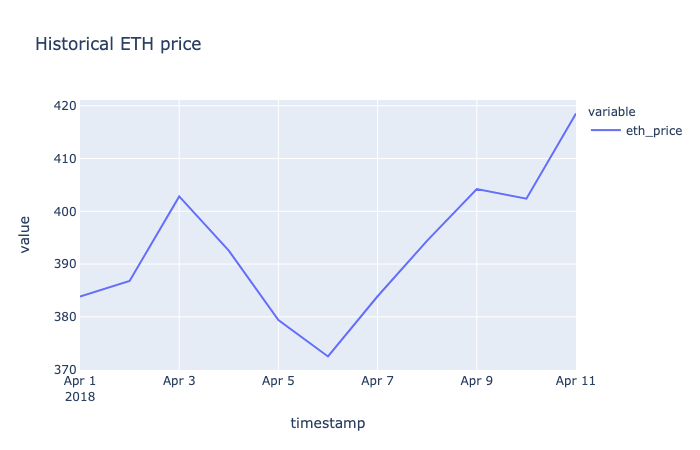

In [31]:
df.plot(x='timestamp', y=['eth_price'], title='Historical ETH price')

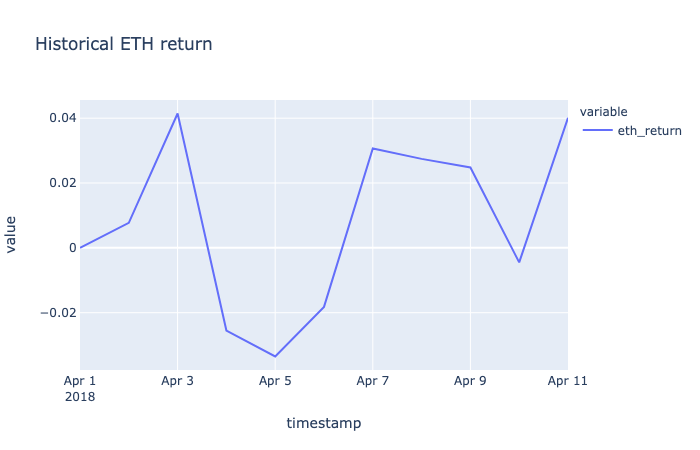

In [32]:
df.plot(x='timestamp', y=['eth_return'], title='Historical ETH return')

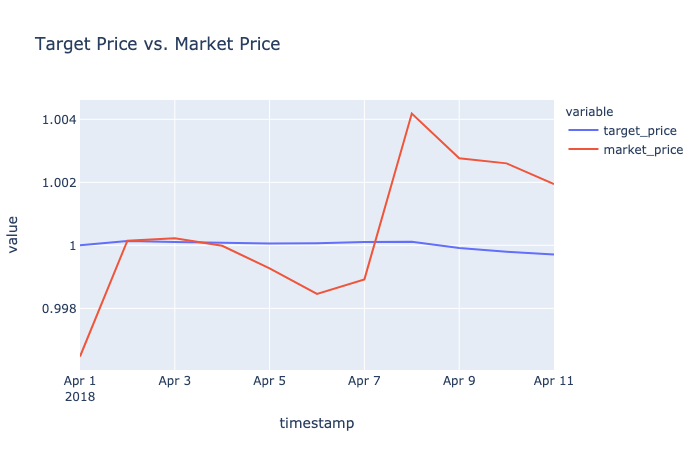

In [33]:
df.plot(x='timestamp', y=['target_price', 'market_price'], title='Target Price vs. Market Price')

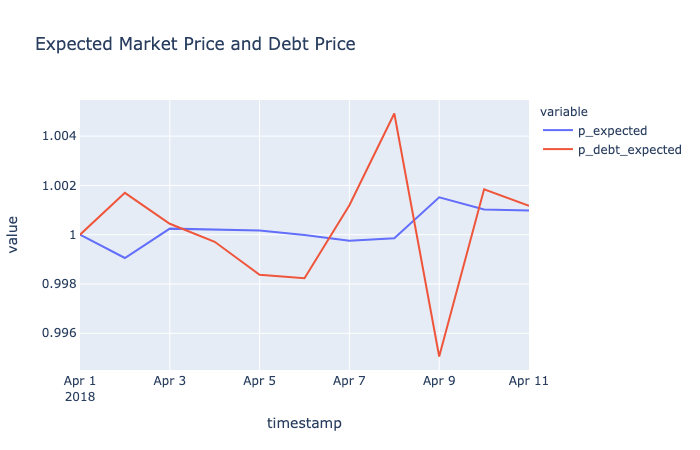

In [34]:
df.plot(x='timestamp', y=['p_expected', 'p_debt_expected'], title='Expected Market Price and Debt Price')

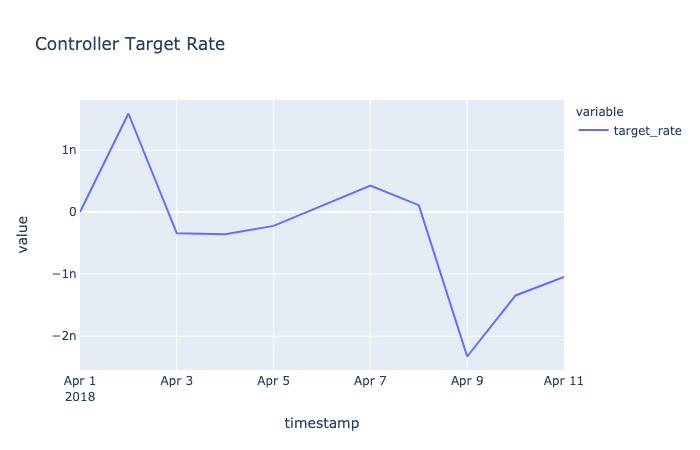

In [35]:
df.plot(x='timestamp', y=['target_rate'], title='Controller Target Rate')

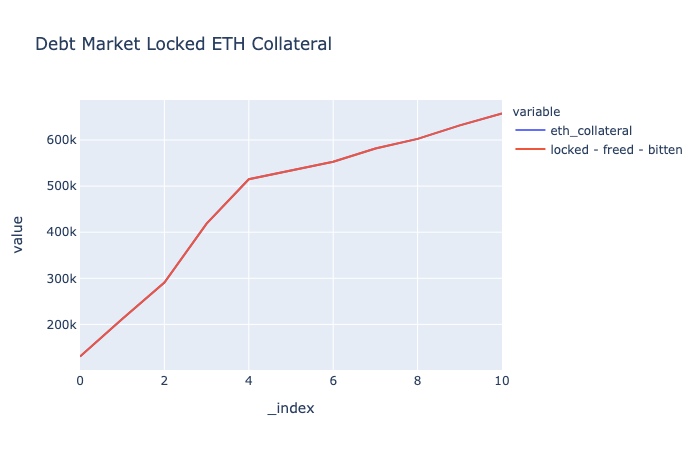

In [36]:
df['locked - freed - bitten'] = df['eth_locked'] - df['eth_freed'] - df['eth_bitten']
df.plot(y=['eth_collateral', 'locked - freed - bitten'], title='Debt Market Locked ETH Collateral')

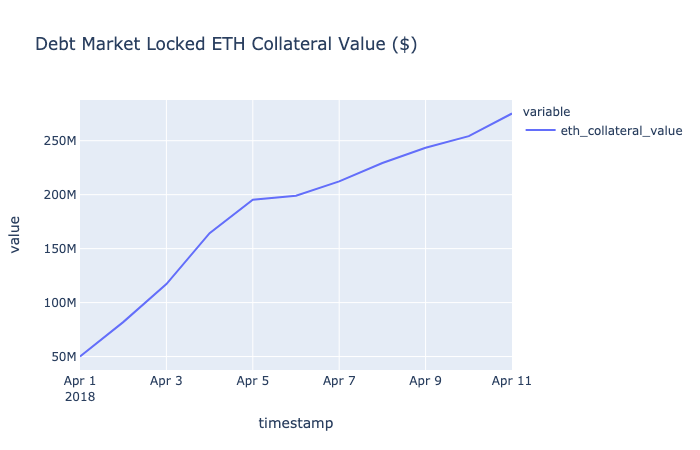

In [37]:
df.plot(x='timestamp', y=['eth_collateral_value'], title='Debt Market Locked ETH Collateral Value ($)')

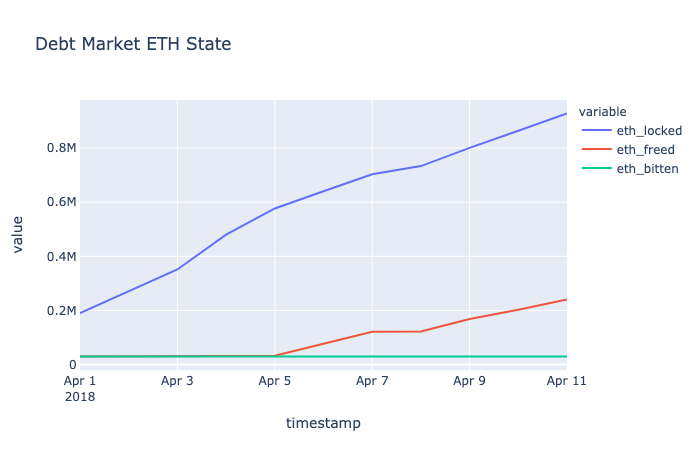

In [38]:
df.plot(x='timestamp', y=['eth_locked', 'eth_freed', 'eth_bitten'], title='Debt Market ETH State')

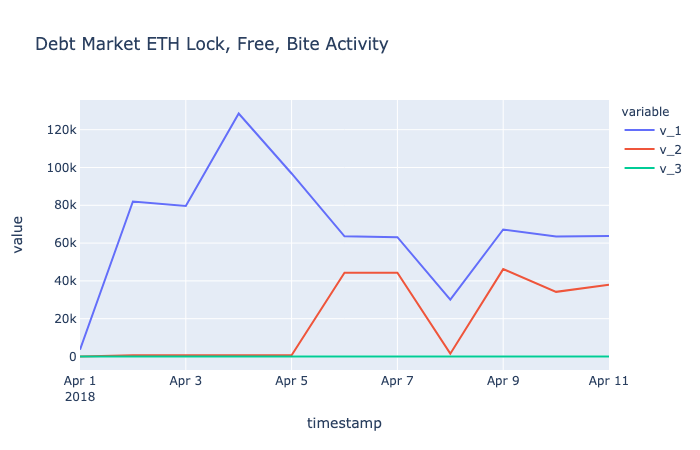

In [39]:
df.plot(x='timestamp', y=['v_1', 'v_2', 'v_3'], title='Debt Market ETH Lock, Free, Bite Activity')

In [40]:
def transform_optimal_values(v):
    try:
        return ast.literal_eval(v)
    except:
        return {}

df['optimal_values'] = df['optimal_values'].map(lambda v: transform_optimal_values(v))

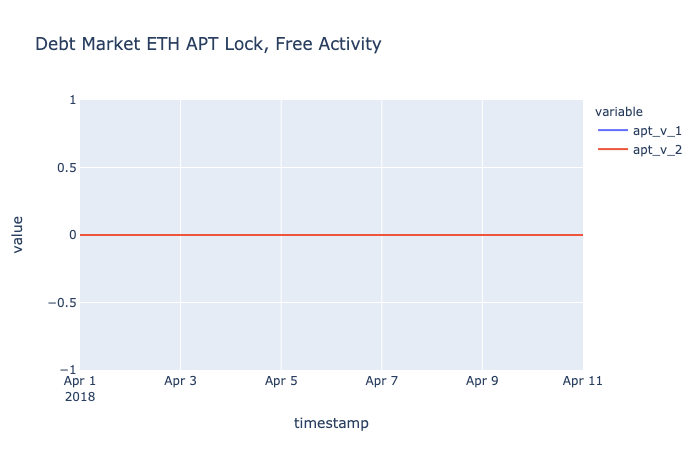

In [41]:
df['apt_v_1'] = df['optimal_values'].map(lambda v: v.get('v_1', 0))
df['apt_v_2'] = df['optimal_values'].map(lambda v: v.get('v_2 + v_3', 0))

df.plot(x='timestamp', y=['apt_v_1', 'apt_v_2'], title='Debt Market ETH APT Lock, Free Activity')

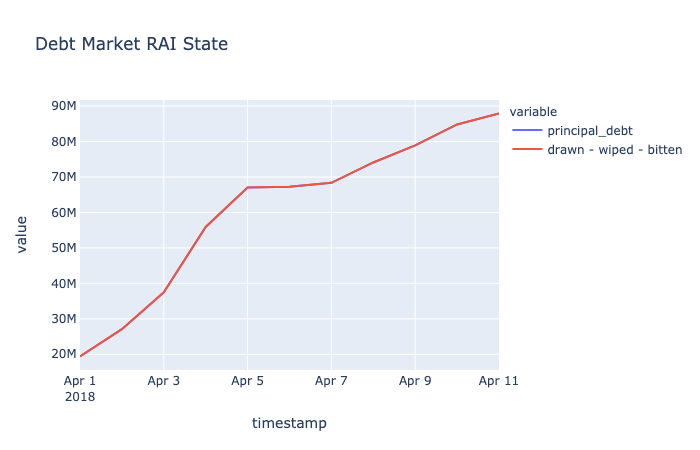

In [42]:
df['drawn - wiped - bitten'] = df['rai_drawn'] - df['rai_wiped'] - df['rai_bitten']
df.plot(x='timestamp', y=['principal_debt', 'drawn - wiped - bitten'], title='Debt Market RAI State')

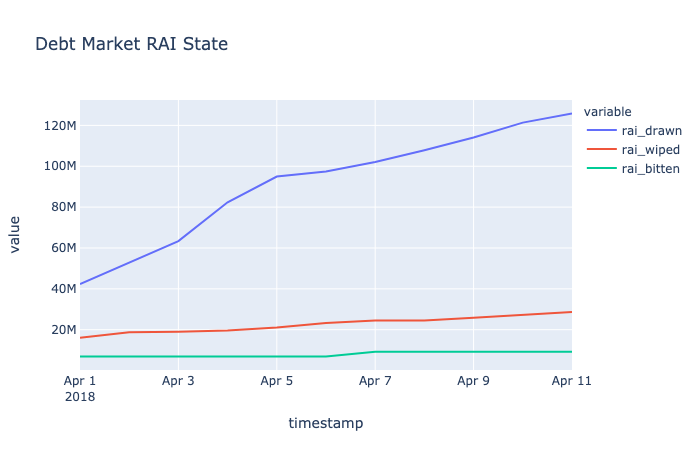

In [43]:
df.plot(x='timestamp', y=['rai_drawn', 'rai_wiped', 'rai_bitten'], title='Debt Market RAI State')

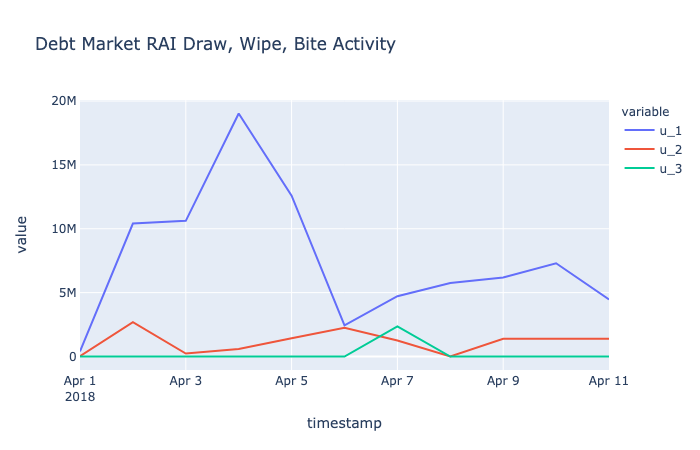

In [44]:
df.plot(x='timestamp', y=['u_1', 'u_2', 'u_3'], title='Debt Market RAI Draw, Wipe, Bite Activity')

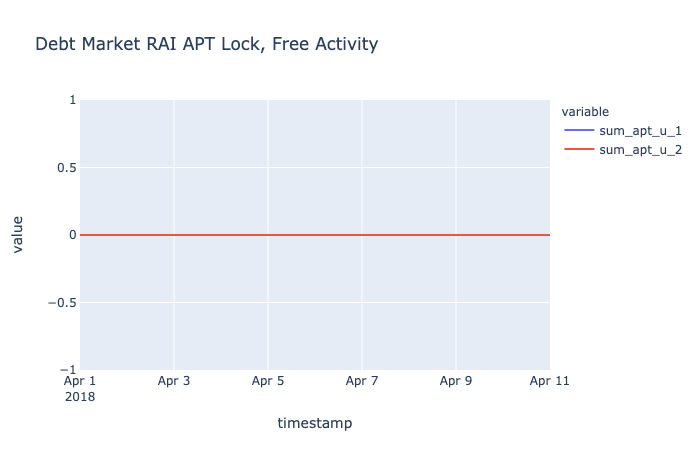

In [45]:
df['sum_apt_u_1'] = df['optimal_values'].map(lambda v: v.get('u_1', 0))
df['sum_apt_u_2'] = df['optimal_values'].map(lambda v: v.get('u_2', 0))

df.plot(x='timestamp', y=['sum_apt_u_1', 'sum_apt_u_2'], title='Debt Market RAI APT Lock, Free Activity')

## Accrued interest and system revenue

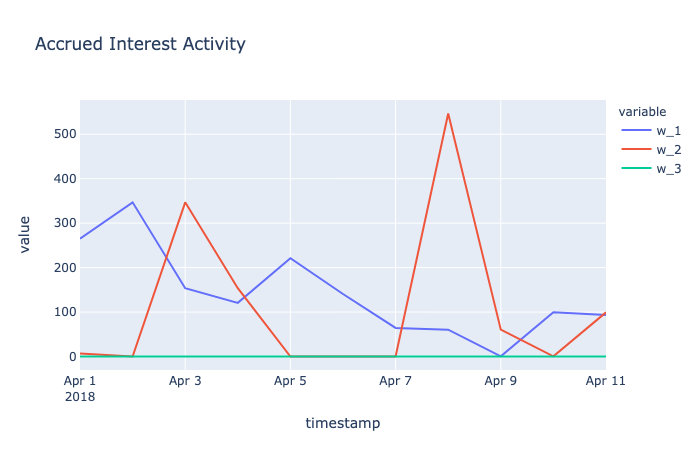

In [46]:
df.plot(x='timestamp', y=['w_1', 'w_2', 'w_3'], title='Accrued Interest Activity')

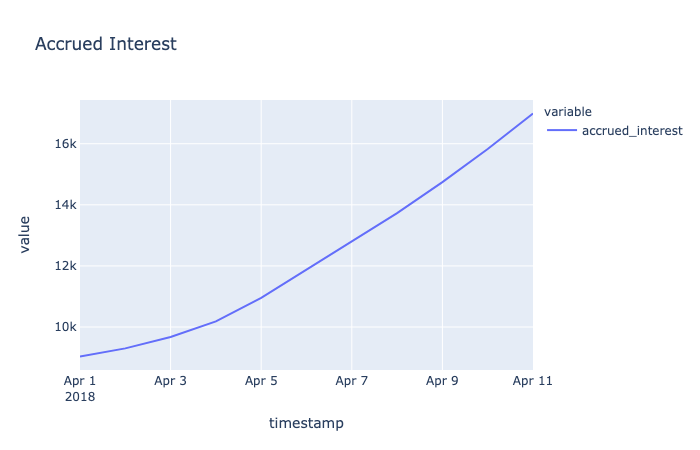

In [47]:
df.plot(x='timestamp', y=['accrued_interest'], title='Accrued Interest')

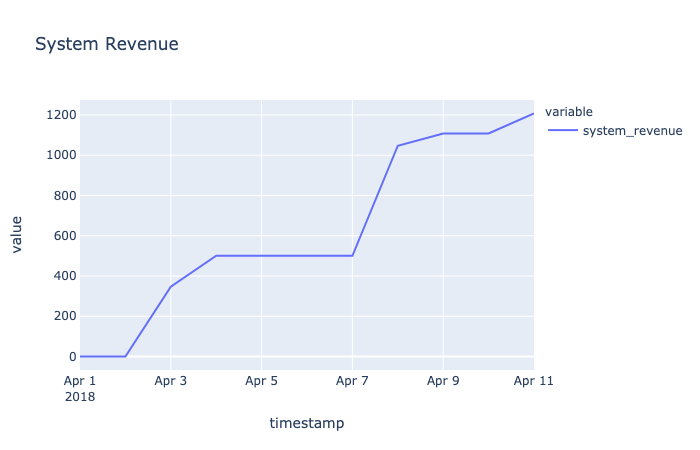

In [48]:
df.plot(x='timestamp', y=['system_revenue'], title='System Revenue')

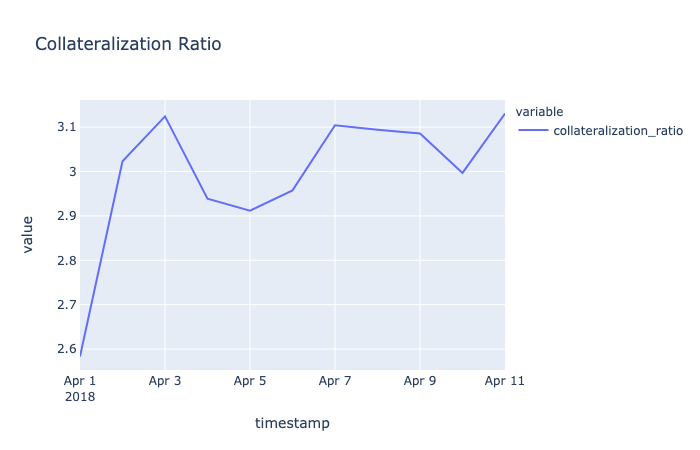

In [49]:
df.plot(x='timestamp', y=['collateralization_ratio'], title='Collateralization Ratio')

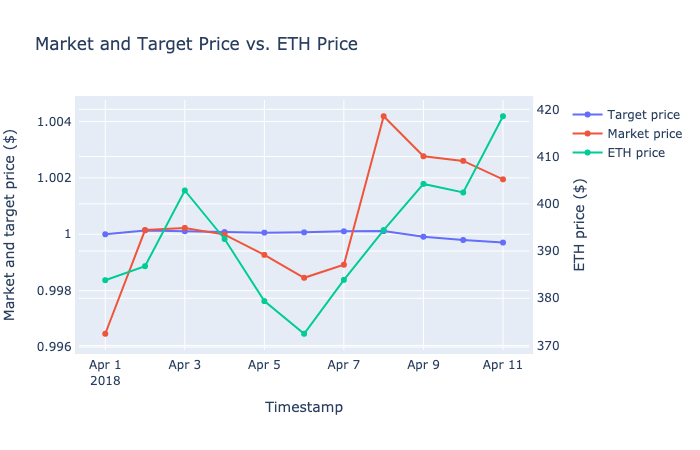

In [50]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['target_price'], name="Target price"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['market_price'], name="Market price"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['eth_price'], name="ETH price"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Market and Target Price vs. ETH Price"
)

# Set x-axis title
fig.update_xaxes(title_text="Timestamp")

# Set y-axes titles
fig.update_yaxes(title_text="Market and target price ($)", secondary_y=False)
fig.update_yaxes(title_text="ETH price ($)", secondary_y=True)

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)

fig.show()

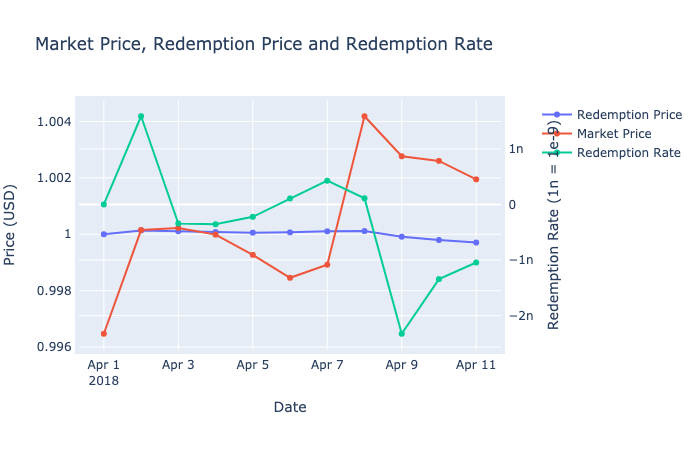

In [51]:

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Add traces
fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['target_price'], name="Redemption Price"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['market_price'], name="Market Price"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['target_rate'], name="Redemption Rate"),
    secondary_y=True,
)
# Add figure title
fig.update_layout(
    title_text="Market Price, Redemption Price and Redemption Rate"
)
# Set x-axis title
fig.update_xaxes(title_text="Date")
# Set y-axes titles
fig.update_yaxes(title_text="Price (USD)", secondary_y=False)
fig.update_yaxes(title_text="Redemption Rate (1n = 1e-9)", secondary_y=True)

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)

fig.show()

## Simulation statistics

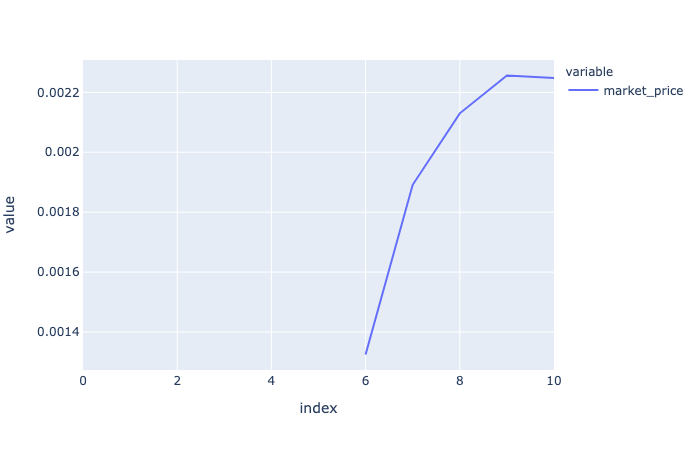

In [66]:
std_mkt = df['market_price'].rolling(7).std()
std_mkt.plot()

In [53]:
np.std(df['market_price'])

0.0021334803852450096

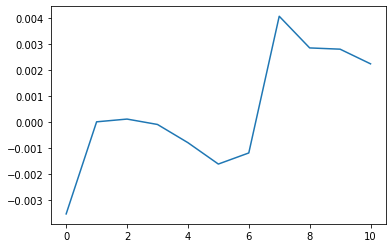

In [54]:
err_m_t = df['market_price'] - df['target_price']
plt.plot(err_m_t)

In [55]:
np.sqrt(abs(df['market_price'] - df['target_price']).mean())

0.04188888154878911

In [56]:
np.corrcoef(df['market_price'],df['eth_price'])

array([[1.        , 0.66079667],
       [0.66079667, 1.        ]])

In [57]:
np.corrcoef(df['market_price'],df['target_price'])

array([[ 1.        , -0.35104812],
       [-0.35104812,  1.        ]])

In [58]:
np.corrcoef(df['market_price'],df['target_rate'])

array([[ 1.        , -0.45241794],
       [-0.45241794,  1.        ]])

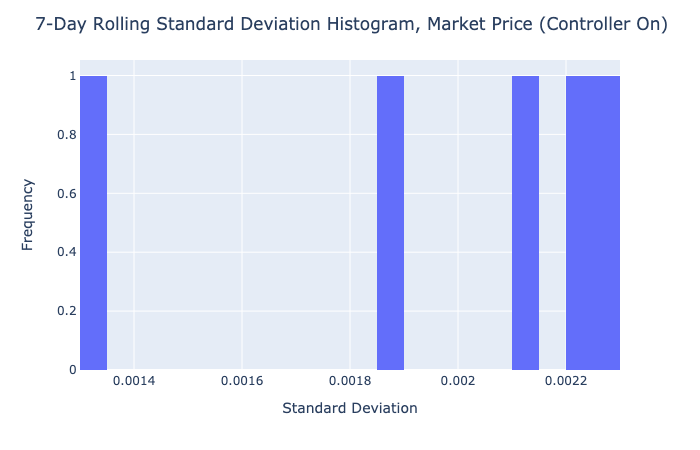

In [59]:

df['market_price_rolling'] = df['market_price'].rolling(7).std()
fig = px.histogram(df, x="market_price_rolling", nbins=25)

fig.update_layout(
    title="7-Day Rolling Standard Deviation Histogram, Market Price (Controller On)",
    xaxis_title="Standard Deviation",
    yaxis_title="Frequency",
)

fig.show()

In [ ]:

# std_mkt_without = res_without_controller[‘market_price’].rolling(7).std()
# std_mkt_with = res_with_controller[‘market_price’].rolling(7).std()
# df =pd.DataFrame(dict(
#     series=np.concatenate(([“With Controller”]*len(std_mkt_with), [“Without Controller”]*len(std_mkt_without))),
#     data  =np.concatenate((std_mkt_with,std_mkt_without))
# ))

# fig = df.hist(x=“data”, color=“series”, nbins=25, barmode=“overlay”,
#         labels={
#             ‘count’ : “Count”,
#             ‘data’ : “Std Dev”,
#             ‘series’ : “Simulation”
#         },
#         title=“Histogram, Standard Deviations of Market Price”)
# fig.show()